In [ ]:
# default_exp cnn_oc_svm

# cnn_oc_svm

> Contains the base class for the CNN OC-SVM model. Override the SVM or CNN as desired but used directly is optimized for the MNIST example case.

In [ ]:
#hide
from nbdev.showdoc import *
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
#export
class cnn_oc_svm:
    """
    The base-class with simple CNN and OC-SVM. 
    """
    pass

### Basic neural net for mnist digits
Let's build a quick neural net in pytorch to classify MNIST digits. I'm assuming if you're this far deep into machine learning, you likely have encountered this before. If you are unsure about the basics of Neural Networks as classifiers, you should check out an in depth tutorial for the nitty-gritty details. We're doing this in a standard but terse approach.

### The general idea:

In training a neural network we are transforming images into feature maps and feeding that into the final fully connected layer that corresponds to our classes. Once we have a model with the performance we like, we separate the final layer from the rest of the neural net. We then use this feature extractor on our training set to generate our training data for the one-class SVM.

Why do we care? Because then we can do this on incoming data and check if the incoming image data is anomalous. Depending on your use case this can mean auto-flagging useful and novel future training data or could mean flagging potentially fraudulent or dangerous input.

This will be demonstrated with an MNIST classifier with the hope to have the OC-SVM flag input images that are not numbers but random images, patterns, and possibly even letters.

### Steps:

1. Load up MNIST dataset and setup data pipeline
2. Construct CNN in pytorch and train
3. Freeze model and separate the last fully connected layer from model
    * Ideally we can pass the vector straight to the last layer
4. Use the feature extractor to generate data for our OC-SVM model

Once that is complete we'll have the first component of our lovely model.



### Step 1: Creating the data pipeline

In [ ]:
# Loading up our transformers so images get preprocessed
# TODO Add robust preprocessing so it'll work out of the box for more realistic problems
image_preprocessing_pipeline = transforms.Compose([
                               transforms.ToTensor(), #Convert image to tensor
                               transforms.Normalize((0.5,), (0.5,)), # Normalize RGB values from 0-255 to 0-1
                               ])

# Building dataset
training_data = datasets.MNIST('.', train=True, transform=image_preprocessing_pipeline, download=True)

validation_data = datasets.MNIST('.', train=False, transform=image_preprocessing_pipeline, download=True)

# Setting up data loaders.
training_data_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)


### Step 2: Build the CNN

In [ ]:
input_size = 28 * 28 #Image resolution is 28x28
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
)
model

criterion = nn.NLLLoss() #Negative log-likelihood loss cuz classification



Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

Note the shape of a single image: 
 torch.Size([1, 28, 28])
Post numpy and squeeze gives us a 28x28 matrix representation of our image with shape: 
 (28, 28)
this example image is a 8


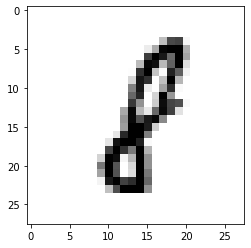

In [ ]:
images, labels = next(iter(training_data_loader))
print(f"Note the shape of a single image: \n {images[0].shape}")
example_image = images[0].numpy().squeeze()
print(f"Post numpy and squeeze gives us a 28x28 matrix representation of our image with shape: \n {example_image.shape}")
plt.imshow(example_image, cmap='gray_r')
print(f"this example image is a {labels[0].item()}")